This is my notebook to mess around with my own code <3 

Don't touch!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydub
import os 
import librosa
import soundfile as sf
import torch
import torchaudio
from torchaudio import transforms
import random
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
sound_label = ["Dog", "Rooster", "Pig", "Cow", "Frog", "Cat", "Hen", "Insects (flying)", "Sheep", "Crow"
                ,"Rain", "Sea waves", "Crackling fire", "Crickets", "Chirping birds", "Water drops", "Wind", "Pouring water", "Toilet flush", "Thunderstorm"
                ,"Crying baby", "Sneezing", "Clapping", "Breathing", "Coughing", "Footsteps", "Laughing", "Brushing teeth", "Snoring", "Drinking, sipping"
                , "Door knock", "Mouse click", "Keyboard typing", "Door, wood creaks", "Can opening", "washing machine", "Vacuum cleaner", "Clock alarm", "Clock tick", "Glass breaking"
                , "Helicopter", "Chainsaw", "Siren", "Car horn", "Engine", "Train", "Church bells", "Airplane", "Fireworks", "Hand saw"]
sounds = dict(zip(range(50), sound_label))

In [7]:
sounds[9]

'Crow'

In [11]:
df = pd.read_csv('../../Dataset/ESC-50-master/meta/esc50.csv')
df.head(10)


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
5,1-101296-B-19.wav,1,19,thunderstorm,False,101296,B
6,1-101336-A-30.wav,1,30,door_wood_knock,False,101336,A
7,1-101404-A-34.wav,1,34,can_opening,False,101404,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
9,1-103995-A-30.wav,1,30,door_wood_knock,False,103995,A


START HERE

In [5]:
class AudioUtil():
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file, format='wav')
        return (sig,sr)
    
    # ----------------------------
    # Standardizing sample rate to 44100Hz
    # ----------------------------
    def resample(audio, srate):
        sig, sr = audio
        if (sr == srate):
            return audio
        no_channels = sig.shape[0]

        #Resample 1st channel:
        resig = torchaudio.transforms.Resample(sr, srate)(sig[:1,:])
        if (no_channels > 1):
            #Resample 2nd channel and merge both
            retwo = torchaudio.transforms.Resample(sr, srate)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, srate))


    # ----------------------------
    # Some audios are mono, some are stereo. We need everything to have the same dimensions.
    # Thus, we can either only select the first channel of stereo or duplicate the first channel of mono
    # ----------------------------
    @staticmethod
    def rechannel(audio, channel):
        sig, sr = audio
        if (sig.shape[0]==channel):
            return audio
        if (channel==1):
            resig = sig[:1,:]
        else:
            resig = torch.cat([sig,sig])

        return ((resig, sr))

    

    # ----------------------------
    # Standardize the length of the audio - that is, either pad or truncate the audio
    # ----------------------------
    @staticmethod
    def resize_aud(audio, ms):
        sig, sr = audio
        no_rows, sig_len = sig.shape
        max_len = sr // 1000 * ms

        #Truncate
        if (sig_len > max_len):
            sig = sig[:, :max_len]
        #Padding
        elif (sig_len < max_len):
            #Length of the paddings at the start and end of the signal
            len_start = random.randint(0, max_len-sig_len)
            len_end = max_len - len_start - sig_len

            pad_start = torch.zeros((no_rows, len_start))
            pad_end = torch.zeros((no_rows, len_end))

            sig = torch.cat((pad_start, sig, pad_end), 1)

        return (sig, sr)


    # ----------------------------
    # Refer to textbox_1 for the reasoning of this method
    # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    # ----------------------------
    # Generating Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(audio, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = audio
        top_db = 80 #if we have more time, we can try 80
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        #shape of spec is [channel (mono or stereo etc), n_mels, time]
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)


    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec
    

                

Textbox_1: We might also need to perform augmentation for raw data. "Natural sounds" such as traffic, sea waves, dog barks,.. usually have no particular order thus the audio could wrap around. On the other hand, human speech and alike sounds, the order matters. We can fill the gaps with silence. There are some options: time shift, pitch shift, time stretch, add noise,... We will try out the first option: time shift

Next, we build a customized Dataloader

In [12]:
class SoundDS(Dataset):
  def __init__(self, df, path):
    self.df = df
    self.path = str(path)
    self.duration = 5000 #our audio is 5 seconds
    self.sr = 44100
    self.channel = 1 #most our training audios are mono, try with 1
    self.shift_pct = 0.4


  def __len__(self):
    return len(self.df)
  
  def __shape__(self):
    return self.df.shape
  
  def __getitem__(self, index):
    file = self.path + self.df.loc[index, 'filename']
    class_id = self.df.loc[index, 'target'] #the index of the label aka target
    fold = self.df.loc[index, 'fold']

    audio = AudioUtil.open(file)
    #print(f"Original shape {audio[0].shape} and sample rate of {audio[1]}")
    rechannel = AudioUtil.rechannel(audio, self.channel)
    #print(f"Rechanneling shape {rechannel[0].shape} and sample rate of {rechannel[1]}")
    resamp = AudioUtil.resample(rechannel, self.sr)
    #print(f"Resampling shape {resamp[0].shape} and sample rate of {resamp[1]}")
    padded = AudioUtil.resize_aud(resamp, self.duration)
    #print(f"Padded shape {padded[0].shape} and sample rate of {padded[1]}")
    shifted = AudioUtil.time_shift(padded, self.shift_pct)
    #print(f"Time shift shape {shifted[0].shape} and sample rate of {shifted[1]}")
    sgram = AudioUtil.spectro_gram(shifted, n_mels=64, n_fft=1024, hop_len=None)
    #print(f"Mel spectrogram shape {sgram.shape}")
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
    #print(f"Augmented spectrogram shape {aug_sgram.shape} of (num_channels, Mel freq_bands, time_steps)")
    return aug_sgram, class_id


In [8]:
data_path = r'../../Dataset/ESC-50-master/audio/'


Splitting for SVM. If you run CNN, ignore it

In [ ]:
data_path = r'../../Dataset/ESC-50-master/audio/'
save_path = r'../../Preprocessed Data/'
np.random.seed(138)
data = SoundDS(df, data_path)
for i in range(5):
    # df_train = df[df.fold != (i+1)]
    # df_test = df[df.fold == (i+1)]
    #data_train = SoundDS(df, data_path)

    #print(type(data_train))
    #data_test = SoundDS(df_test, data_path)
    #print("Data train", data_train.__shape__())
    # Random split of 80:10:10 between testing and validating
    num_items = len(data)
    num_train = round(num_items * 0.8)
    num_val = num_items - num_train
    num_test = round(num_val * 0.5)
    num_val_2 = num_val - num_test
    train_ds, val = random_split(data, [num_train, num_val])
    val_ds, test_ds = random_split(val, [num_val_2, num_test])
    print(type(train_ds), len(train_ds))

    # Create training and validation data loaders
    # train_dl = torch.utils.data.DataLoader(data_train, batch_size=16, shuffle=True)
    # test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)
    # val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)
    # print(train_dl)
    # torch.save(train_dl, save_path + f'X_train_{i+1}.npy')
    # torch.save(test_dl, save_path + f'X_test_{i+1}.npy')
    # torch.save(val_dl, save_path + f'X_val_{i+1}.npy')

    np.save(save_path + f'X_train_{i+1}.npy', train_ds)
    np.save(save_path + f'X_test_{i+1}.npy', test_ds)
    np.save(save_path + f'X_val_{i+1}.npy', val_ds)

In [9]:
# test = np.load(r'../../Preprocessed Data/X_train_1.npy', allow_pickle=True)
# testdf = pd.DataFrame(test, columns = ["Tensor", "Target"])
# testdf.Tensor[0].shape



Trying out a CNN model online

In [43]:
myds = SoundDS(df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
train_df = torch.utils.data.Subset(myds, range(1600))
test_df = torch.utils.data.Subset(myds, range(1600, 2000))
# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [65]:
test_dl = torch.utils.data.DataLoader(test_df, batch_size=16, shuffle=False)

In [60]:


# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)) #change first param if change no_channels
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=50)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

If you don't change any parameters, you can skip this and just use our pre-trained models under Models

In [61]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()


        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  
num_epochs=150
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 3.89, Accuracy: 0.03
Epoch: 1, Loss: 3.82, Accuracy: 0.04
Epoch: 2, Loss: 3.74, Accuracy: 0.05
Epoch: 3, Loss: 3.66, Accuracy: 0.06
Epoch: 4, Loss: 3.57, Accuracy: 0.07
Epoch: 5, Loss: 3.50, Accuracy: 0.09
Epoch: 6, Loss: 3.46, Accuracy: 0.09
Epoch: 7, Loss: 3.41, Accuracy: 0.11
Epoch: 8, Loss: 3.38, Accuracy: 0.12
Epoch: 9, Loss: 3.30, Accuracy: 0.13
Epoch: 10, Loss: 3.25, Accuracy: 0.16
Epoch: 11, Loss: 3.18, Accuracy: 0.18
Epoch: 12, Loss: 3.13, Accuracy: 0.19
Epoch: 13, Loss: 3.05, Accuracy: 0.21
Epoch: 14, Loss: 3.01, Accuracy: 0.21
Epoch: 15, Loss: 2.92, Accuracy: 0.26
Epoch: 16, Loss: 2.87, Accuracy: 0.24
Epoch: 17, Loss: 2.80, Accuracy: 0.25
Epoch: 18, Loss: 2.75, Accuracy: 0.27
Epoch: 19, Loss: 2.65, Accuracy: 0.31
Epoch: 20, Loss: 2.60, Accuracy: 0.31
Epoch: 21, Loss: 2.53, Accuracy: 0.33
Epoch: 22, Loss: 2.47, Accuracy: 0.35
Epoch: 23, Loss: 2.42, Accuracy: 0.36
Epoch: 24, Loss: 2.38, Accuracy: 0.36
Epoch: 25, Loss: 2.31, Accuracy: 0.38
Epoch: 26, Loss: 2.24,

Saving the model trained with 100 epochs on 80 db

In [62]:
PATH = '../../Models/cnn-150random.pt'
torch.save(myModel.state_dict(), PATH)

In [63]:
PATH = r'../../Models/cnn-300random.pt'
#device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AudioClassifier()
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
model.eval()
model.to(device)

AudioClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_features=64, out_features=50, bias=True)
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, mome

In [64]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)
      #print(inputs.shape)
      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
  return acc

# Run inference on trained model with the validation set
inference(model, val_dl)

Accuracy: 0.72, Total items: 400


0.7175

In [15]:
def load_model(path):
    PATH = path
    #device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = AudioClassifier()
    model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
    model.eval()
    model.to(device)
    return model  

Accuracy: 0.56, Total items: 400
Accuracy: 0.79, Total items: 400
Accuracy: 0.56, Total items: 400
Accuracy: 0.66, Total items: 400
Accuracy: 0.56, Total items: 400
Accuracy: 0.70, Total items: 400
Accuracy: 0.56, Total items: 400
Accuracy: 0.74, Total items: 400
Accuracy: 0.65, Total items: 400
Accuracy: 0.75, Total items: 400


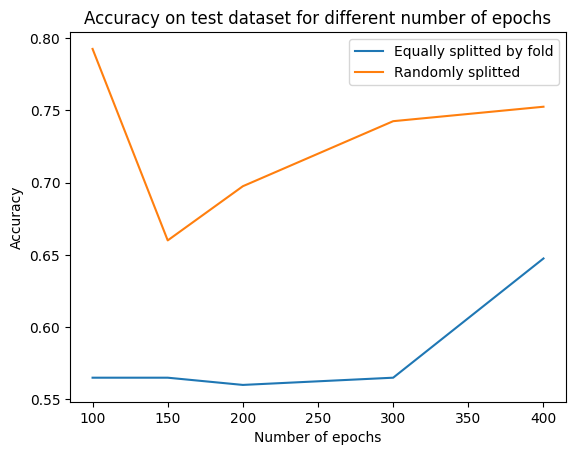

In [71]:
import matplotlib.pyplot as plt
no_epochs = [100, 150, 200, 300, 400]
model100 = load_model(r'../../Models/cnn-100equalsplit.pt')
model150 = load_model(r'../../Models/cnn-150.pt')
model200 = load_model(r'../../Models/cnn-200.pt')
model300 = load_model(r'../../Models/cnn-300.pt')
model400 = load_model(r'../../Models/cnn-400.pt')
model100r = load_model(r'../../Models/cnn-100random.pt')
model150r = load_model(r'../../Models/cnn-150random.pt')
model200r = load_model(r'../../Models/cnn-200random.pt')
model300r = load_model(r'../../Models/cnn-300random.pt')
model400r = load_model(r'../../Models/cnn-400random.pt')
models = [model100, model150, model200, model300, model400]
models_r = [model100r, model150r, model200r, model300r, model400r]
accuracy = []
accuracyr = []
for i in range(len(no_epochs)):
    a = inference(models[i], test_dl)
    ar = inference(models_r[i], val_dl)
    accuracy.append(a)
    accuracyr.append(ar)

plt.plot(no_epochs, accuracy, label="Equally splitted by fold")
plt.plot(no_epochs, accuracyr, label="Randomly splitted")
plt.legend()
plt.title("Accuracy on test dataset for different number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.show()


In [32]:
model10011 = load_model(r'../../Models/cnn-100equalsplit.pt')
inference(model10011, val_dl)

Accuracy: 0.56, Total items: 400


0.5625

"End to end" methods

In [42]:
# #helper funciton to find the most frequent number in a list
# def most_frequent(listA):
#     res = max(set(listA), key = listA.count)
#     return res

In [23]:
def endtoend(model, audiofile):
    audio = AudioUtil.open(audiofile)
    rechannel = AudioUtil.rechannel(audio, 1) #change number of channel
    resamp = AudioUtil.resample(rechannel, 44100)

    padded = AudioUtil.resize_aud(resamp, 5000)
    shifted = AudioUtil.time_shift(padded, 0.4)
    sgram = AudioUtil.spectro_gram(shifted, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
    input_loader = torch.utils.data.DataLoader(aug_sgram, batch_size=16, shuffle=False)
    
    for input in input_loader:
        #print(input.shape)
        input = input.reshape([-1,1,64,430]) #change 2nd number as u change number of channel
        #print(input.shape)
        input_m, input_s = input.mean(), input.std()
        input = (input - input_m) / input_s
        output = model(input)
        _, prediction = torch.max(output,1)
        prediction = prediction.numpy()[0]
        #print(f"I think this is the sound of a {sounds[prediction]}")
    return prediction 
    

In [27]:
file = r'../../Dataset/ESC-50-master/audio/5-200334-B-1.wav'
real_label = int(file.split("-")[-1].split(".")[0])
prediction = endtoend(model, file)
print(f"I think this is the sound of a {sounds[prediction]}")
print(f"This is actually the sound of a {sounds[real_label]}")


I think this is the sound of a Rooster
This is actually the sound of a Rooster


## Good ones: 

- Usually are loud and clear noises

- For animals (3,4,6,..) sounds, the accuracy is very good and the CNN model is able to predict them correctly most of the time

- Hand saw, church bells

## Bad ones:

- Clock alarm vs glass breaking

- Clock alarms water drops

- Coughing vs water drops

This section is where I test some sounds I found online, which leads to the conclusions following the code cell

In [74]:

ifile = r'../../Internet Audio/cockmono.wav'
prediction_online = endtoend(model, ifile)
print(f"I think this is the sound of a {sounds[prediction_online]}")


I think this is the sound of a Siren


## Some notation from playing around

- Our training audios are of format s16le : PCM signed 16-bit little-endian. Thus, if the audio has wider range, such as s24 or s32 (meaning the more detailed the audio has), accuracy is very low/prediction is not as good?, especially if the sound has background noises

- 2 approaches: turn all mono to poly or turn all poly to mono. We're using the former methods but the poly test files don't really give good results. For the latter model, it seems that it works better on poly files now. 

For more example, this link seems useful: https://bigsoundbank.com/search?q=

Try to choose monophonic example with 16 bit depth. Other examples are ok to test how our model would fail/success in those cases. 

Next step: Fix the website - now always return coughing (maybe we should consider dealing w background noise?)

Divide a (polyphonic) audio into pieces of 5 secs. For each piece, feed it through the endtoend to predict the label

Try out wav2vec, CNN14

### This is where I test tagging audio with time frame

In [76]:
def audioWithTime(model, audiofile):
    audio_dir = r'../../Long Audio/original'
    out_dir = r'../../Long Audio/split'
    audio_file = os.path.join(audio_dir, audiofile)
    wave, sr = librosa.load(audio_file, sr=None) 
    frame_length = 5 #cut into 5s 
    segment_length = int(sr * frame_length)
    num_sections = int(np.ceil(len(wave) / segment_length)) #the number of sections after splitting
    split = []    
    for s in range(0, len(wave), segment_length):
        t = wave[s: s + segment_length]
        split.append(t)
    outfiles = []
    recording_name = os.path.basename(audio_file[:-4])
    for i, segment in enumerate(split):
        out_file = f"{recording_name}_{i}.wav"
        outfiles.append(out_file)
        sf.write(os.path.join(out_dir, out_file), segment, sr)
    splittedfiles = dict(zip(range(len(outfiles)), outfiles))
    #predictions = []
    for f in splittedfiles:
        prediction = endtoend(model,out_dir + "/" + splittedfiles[f])
        print(f"From {f*5}s to {(f+1)*5}s, it sounds like a {sounds[prediction]}")

        

order: 

- coughing 

- laughing or sneezing to show that it also shows coughing

- dog

- cock

- cow

- human cow

- clapping

- alarm clocks



In [97]:
longfile = "keyboard30s.wav"
audioWithTime(model,longfile)

From 0s to 5s, it sounds like a Mouse click
From 5s to 10s, it sounds like a Mouse click
From 10s to 15s, it sounds like a Clapping
From 15s to 20s, it sounds like a Coughing
From 20s to 25s, it sounds like a Mouse click
From 25s to 30s, it sounds like a Coughing
From 30s to 35s, it sounds like a Coughing
